#### Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False)

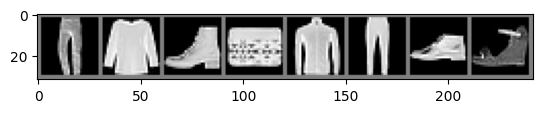

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [4]:
import torch
import torch.nn as nn
from torchsummary import summary

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2) 
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(12*12*32, 128)
        self.dense2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x

model = CustomModel()
model = model.to(device)

# Print model
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
         MaxPool2d-3           [-1, 32, 12, 12]               0
           Flatten-4                 [-1, 4608]               0
            Linear-5                  [-1, 128]         589,952
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.26
Estimated Total Size (MB): 2.62
----------------------------------------------------------------


#### Loss, Optimizer, and Evaluation Function

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

#### Train

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/150], Loss: 1.2998, Accuracy: 65.43%, Test Loss: 0.7856, Test Accuracy: 74.42%
Epoch [2/150], Loss: 0.6574, Accuracy: 78.01%, Test Loss: 0.5980, Test Accuracy: 79.14%
Epoch [3/150], Loss: 0.5381, Accuracy: 81.68%, Test Loss: 0.5224, Test Accuracy: 81.82%
Epoch [4/150], Loss: 0.4800, Accuracy: 83.72%, Test Loss: 0.4807, Test Accuracy: 83.11%
Epoch [5/150], Loss: 0.4446, Accuracy: 84.78%, Test Loss: 0.4520, Test Accuracy: 84.05%
Epoch [6/150], Loss: 0.4192, Accuracy: 85.57%, Test Loss: 0.4324, Test Accuracy: 84.72%
Epoch [7/150], Loss: 0.3995, Accuracy: 86.24%, Test Loss: 0.4155, Test Accuracy: 85.53%
Epoch [8/150], Loss: 0.3846, Accuracy: 86.78%, Test Loss: 0.4023, Test Accuracy: 85.86%
Epoch [9/150], Loss: 0.3719, Accuracy: 87.23%, Test Loss: 0.3948, Test Accuracy: 86.21%
Epoch [10/150], Loss: 0.3623, Accuracy: 87.57%, Test Loss: 0.3815, Test Accuracy: 86.84%
Epoch [11/150], Loss: 0.3519, Accuracy: 87.84%, Test Loss: 0.3740, Test Accuracy: 86.73%
Epoch [12/150], Loss: 0.3427, 

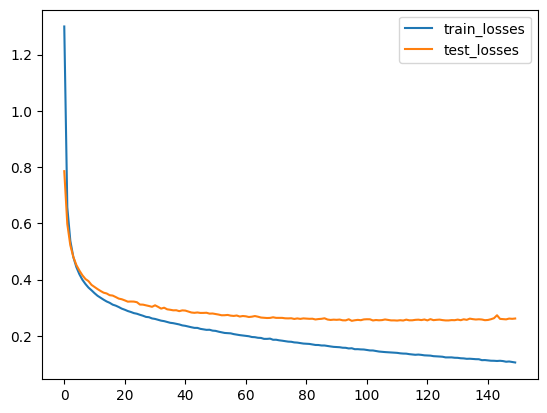

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

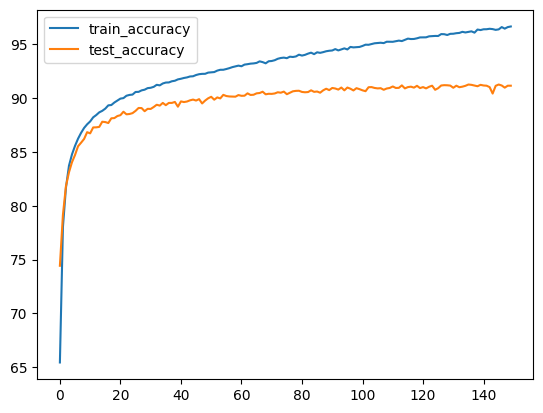

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()